<a href="https://colab.research.google.com/github/tomik062/AI_Project/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

extract data from github and merge together

In [1]:
import requests
import os
import importlib.util
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV, LeaveOneOut,KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Define the GitHub details
def init_process():
  repo_owner = 'tomik062'
  repo_name = 'AI_Project'
  file_path = 'extract_data.py'
  url = f'https://raw.githubusercontent.com/{repo_owner}/{repo_name}/main/{file_path}'

  # Directory to save the downloaded file
  download_dir = 'data_extraction_code'
  if not os.path.exists(download_dir):
      os.makedirs(download_dir)

  local_file_path = os.path.join(download_dir, file_path)

  # Download the file
  response = requests.get(url)
  response.raise_for_status() # Raise an exception for bad status codes

  with open(local_file_path, 'wb') as f:
      f.write(response.content)

  print(f"Downloaded {file_path} to {local_file_path}")

  # Import the function from the downloaded file
  spec = importlib.util.spec_from_file_location("extract_data_module", local_file_path)
  module = importlib.util.module_from_spec(spec)
  spec.loader.exec_module(module)
  # Call the extract_data function and print the output
  return module.extract_data()

In [2]:
def calc_features_year(data,year):
    feature_map = {
        'urbanization': 0,
        'avg birth age': 1,
        'happiness index': 2,
        'health expenditure': 3,
        'physicians per capita': 4,
        'GNI PPP': 5,
        'female labor participation': 6,
        'christians (%)': 7,
        'muslims (%)': 8,
        'no religion (%)': 9,
        'buddhists (%)': 10,
        'hindus (%)': 11,
        'jews (%)': 12,
        'other religion (%)': 13,
        'in Asia-Pacific':14,
        'in Europe':15,
        'in Latin America-Caribbean':16,
        'in Middle East-North Africa':17,
        'in North America':18,
        'in Sub-Saharan Africa':19,
        'post-HS education men (%)': 20,
        'Post-HS education women (%)': 21,
        'human development index': 22,
        'gender inequality index': 23,
        'first marriage age women': 24,
        'first marriage age men': 25,
        'maternity leave index': 26,
        'work hours men': 27,
        'work hours women': 28,
        'abortion rate': 29,
        'social media users': 30
    }
    countries_with_data = sorted(list(set([key[0] for key in data.keys() if key[1] == year])))
    index = pd.MultiIndex.from_product([countries_with_data, [year]], names=['country', 'year'])
    df = pd.DataFrame(index=index, columns=feature_map.keys())
    target=[]
    # Populate the DataFrame
    for (country, yr) in index:
        key = (country, yr)
        features = data[key][1]
        target.append(data[key][0])
        for feature_name, feature_index in feature_map.items():
            if feature_index < len(features):
              df.loc[key, feature_name] = features[feature_index]
              if str(features[feature_index]) =='nan':
                df.loc[key, feature_name]=handle_missing_values(data,feature_index,country,year)
    return df,target



def handle_missing_values(data, feature_index, country, year):
    # try taking the value from the last 3 years
    for i in range(1, 4):
        past_year = year - i
        if (country, past_year) in data:
            past_data = data[(country, past_year)][1] # Access the list of features
            if feature_index < len(past_data) and str(past_data[feature_index])!='nan':
                return past_data[feature_index]

    # otherwise if missing last 3 years, linearly extrapulate from last decade
    recent_years_data = []
    for i in range(10,0,-1):
        past_year = year - i
        if (country, past_year) in data:
            past_data = data[(country, past_year)][1] # Access the list of features
            if feature_index < len(past_data) and not pd.isna(past_data[feature_index]):
                 recent_years_data.append((past_year, past_data[feature_index]))

    if len(recent_years_data) >= 2:
        years = [item[0] for item in recent_years_data]
        values = [item[1] for item in recent_years_data]
        last_value = values[-1]
        # Linear extrapolation using linear regression with polyfit
        try:
            m, c = np.polyfit(years, values, 1)
            extrapolated_value = m * year + c

            # Check if extrapolated value is within 50% of last value
            if last_value != 0 and abs(extrapolated_value - last_value) / abs(last_value) > 0.5:
                return last_value
            elif last_value == 0 and abs(extrapolated_value) > 0.5 * np.mean(values): # Handle edge case where last_value is 0
                 return last_value
            else:
                return extrapolated_value
        except np.linalg.LinAlgError:
            # Handle cases where polyfit fails (e.g., all years are the same)
            return last_value # Return the last known value
    elif len(recent_years_data) == 1:
         # If only one data point in the last 10 years, use that value
         return recent_years_data[0][1]

    # If still missing after checking last 10 years, return NaN
    return np.nan

In [3]:
def find_missing_features(df_features):

  # Identify countries with and without NaN values
  countries_with_nan = df_features[df_features.isnull().any(axis=1)].index.tolist()
  countries_without_nan = df_features.dropna().index.tolist()
  countries_with_one_nan = df_features[df_features.isnull().sum(axis=1) == 1].index.tolist()

  # Print the results
  print("Countries with NaN values in their features:")
  print(countries_with_nan)
  print("\nCountries without NaN values in their features:")
  print(countries_without_nan)
  print("\nCountries with exactly one NaN value in their features:")
  print(countries_with_one_nan)

  print(f"\nNumber of countries with NaN values: {len(countries_with_nan)}")
  print(f"Number of countries without NaN values: {len(countries_without_nan)}")
  print(f"Number of countries with exactly one NaN value: {len(countries_with_one_nan)}")

  # Group countries by their single missing feature
  missing_features_grouped = {}
  if countries_with_one_nan:
      for country in countries_with_one_nan:
          missing_feature_name = df_features.loc[country].isnull().idxmax()
          if missing_feature_name not in missing_features_grouped:
              missing_features_grouped[missing_feature_name] = []
          missing_features_grouped[missing_feature_name].append(str(country))

      # Print countries grouped by missing feature
      print("\nMissing feature for countries with exactly one NaN:")
      for feature, countries in missing_features_grouped.items():
          print(f"  Missing feature is '{feature}':")
          print(f"    Countries: {', '.join(countries)}")

process 2023 data:
add some missing data, split to train and test and normalize

In [4]:
def process_2023_data(data_output):
    df_features, target = calc_features_year(data_output, 2023)
    missing_values_to_fill = {
        'abortion rate': {
            'Cyprus': 7,'Ireland': 6.7,'Malaysia': 11,
            'Mauritania': 42,'Malta': 3,'Morocco': 25, 'Congo, Rep.': 39
        },
        'maternity leave index': {
            'Albania': 23.23,'Bosnia and Herzegovina': 52.14,
            'Kazakhstan': 18,'Georgia': 7.59,'Kyrgyz Republic': 18,
            'Moldova': 18,'Angola': 13,'Armenia': 20,
            'Azerbaijan': 18,'Malawi': 12.86,'Bhutan': 8,
            'Tanzania': 12,'Tajikistan': 20,'North Macedonia': 39,
            'Liberia': 12.86,'Suriname': 0,'Uzbekistan': 18
        },
        'gender inequality index':{
            'Central African Republic':0.682
        }
    }

    # Fill in missing values using the dictionary
    for feature, country_values in missing_values_to_fill.items():
        for country, value in country_values.items():
            if (country,2023) in df_features.index:
                df_features.loc[(country,2023), feature] = value

    # Convert all columns to numeric, coercing errors
    df_features = df_features.apply(pd.to_numeric, errors='coerce')

    # Create a DataFrame for the target variable
    y = pd.Series(target, index=df_features.index, name='target')

    # Combine features and target into a single DataFrame for easier NaN handling
    combined_df = pd.concat([df_features, y], axis=1)

    # Remove rows with NaN values
    combined_df_cleaned = combined_df.dropna()

    # Separate features and target again
    X = combined_df_cleaned.drop('target', axis=1)
    y = combined_df_cleaned['target']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [5]:
def plot_features(X_train):

  # Get the list of columns
  columns = X_train.columns

  # Calculate the number of rows needed
  n_cols = 5
  n_rows = math.ceil(len(columns) / n_cols)

  # Create subplots
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
  axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

  # Plot histograms for all features
  for i, column in enumerate(columns):
      axes[i].hist(X_train[column], bins=10)
      axes[i].set_title(f'Histogram of {column}')
      axes[i].set_xlabel(column)
      axes[i].set_ylabel('Frequency')
      axes[i].grid(True)

  # Hide any unused subplots
  for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

In [6]:
class Scaling2023(BaseEstimator, TransformerMixin):
    def __init__(self,log_features=None,features_to_scale=None,health_features=None):
        self.log_features=log_features or ['no religion (%)','other religion (%)','buddhists (%)','hindus (%)','jews (%)','GNI PPP']
        self.health_features=health_features or ['physicians per capita','health expenditure']
        self.features_to_scale=features_to_scale or [
            'urbanization','avg birth age','happiness index','GNI PPP','female labor participation','christians (%)','muslims (%)','no religion (%)',
            'buddhists (%)','hindus (%)','jews (%)','other religion (%)','post-HS education men (%)','post-HS education men (%)',
            'human development index','gender inequality index','first marriage age women','first marriage age men','maternity leave index',
            'work hours men','work hours women','abortion rate','social media users','healthcare index score'
        ]
        self.health_scaler=StandardScaler()
        self.scaler=StandardScaler()

    def fit(self,X,y=None):
        X_copy=X.copy()
        missing=[c for c in (self.health_features+self.log_features) if c not in X_copy.columns]
        if missing: raise KeyError(f"Missing columns: {missing}")

        self.health_scaler.fit(X_copy[self.health_features])
        h_scaled=self.health_scaler.transform(X_copy[self.health_features])
        score=h_scaled[:,0]+h_scaled[:,1]
        X_copy=X_copy.drop(columns=self.health_features)
        X_copy['healthcare index score']=score
        for f in self.log_features:
            X_copy[f]=pd.to_numeric(X_copy[f])
            X_copy[f]=np.log1p(X_copy[f])
        self.scaler.fit(X_copy[self.features_to_scale])
        return self

    def transform(self,X):
        X_copy=X.copy()
        h_scaled=self.health_scaler.transform(X_copy[self.health_features])
        score=h_scaled[:,0]+h_scaled[:,1]
        X_copy=X_copy.drop(columns=self.health_features)
        X_copy['healthcare index score']=score
        for f in self.log_features:
            X_copy[f]=pd.to_numeric(X_copy[f])
            X_copy[f]=np.log1p(X_copy[f])
        X_copy[self.features_to_scale]=self.scaler.transform(X_copy[self.features_to_scale])
        return X_copy

In [8]:
def create_health_index_score(X_train,X_test):
    scaler_healthcare = StandardScaler()
    health_features = ['physicians per capita','health expenditure']
    X_train[health_features] = scaler_healthcare.fit_transform(X_train[health_features])
    X_test[health_features] = scaler_healthcare.transform(X_test[health_features])
    X_train['healthcare index score'] = X_train['physicians per capita'] + X_train['health expenditure']
    X_test['healthcare index score'] = X_test['physicians per capita'] + X_test['health expenditure']
    X_train = X_train.drop(['physicians per capita', 'health expenditure'], axis=1)
    X_test = X_test.drop(['physicians per capita', 'health expenditure'], axis=1)
    return X_train,X_test

In [9]:
def feature_correlations(df, method):
    """Calculates and visualizes correlation matrix, and prints top 5 correlated pairs."""

    correlation_matrix = df.corr(method=method)

    plt.figure(figsize=(18, 15))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
    plt.title(f'{method.capitalize()} Correlation Heatmap of Features in X_train')
    plt.show()

    print(f"\nTop 5 most highly correlated pairs of features (absolute {method.capitalize()} correlation):")
    upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    stacked_corr = upper_tri.stack().sort_values(ascending=False, key=abs)
    top_5_correlated_pairs = stacked_corr.head(5)

    if top_5_correlated_pairs.empty:
        print("No correlated pairs found.")
    else:
        for (feature1, feature2), correlation in top_5_correlated_pairs.items():
            print(f"  {feature1} and {feature2}: {correlation:.4f}")


In [10]:
def analyze_target_correlation(X, y, method_name):
    combined_data = pd.concat([X, y], axis=1)
    correlation_series = combined_data.corr(method=method_name)['target'].drop('target').sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')
    plt.title(f'{method_name} Correlation of Features with Target Variable')
    plt.xlabel(f'{method_name} Correlation Coefficient')
    plt.ylabel('Features')
    plt.show()

    print(f"\n{method_name} Correlation with Target:")
    print(correlation_series)


In [10]:
def analyze_mutual_information(X, y):
    """Calculates and displays Mutual Information scores of features with the target."""
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    print("Mutual Information Scores of Features with Target Variable:")
    print(mi_scores)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=mi_scores.values, y=mi_scores.index, palette='viridis')
    plt.title('Mutual Information Scores of Features with Target Variable')
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

In [11]:
def gridsearch_loocv_lasso(X,y):
    pipe=Pipeline([('scaling2023',Scaling2023()),('lasso',Lasso())])
    param_grid={'lasso__alpha':[val*(10**i) for i in range(-12,4) for val in [1,2,5]]}
    gs=GridSearchCV(pipe,param_grid,cv=LeaveOneOut(),scoring='neg_mean_squared_error',n_jobs=-1)
    gs.fit(X,y)
    return gs

def gridsearch_elastic_net_loocv(X,y):
    pipe=Pipeline([('scaling2023',Scaling2023()),('elastic',ElasticNet())])
    param_grid={
        'elastic__alpha':[val*(10**i) for i in range(-6,2) for val in [1,2,5]],
        'elastic__l1_ratio':[0.1,0.3,0.5,0.7,0.9,0.95,0.99,0.995,1.0]
    }
    gs=GridSearchCV(pipe,param_grid,cv=LeaveOneOut(),scoring='neg_mean_squared_error',n_jobs=-1)
    gs.fit(X,y)
    return gs

def gridsearch_random_forest(X,y):
  pipe=Pipeline([('scaling2023',Scaling2023()),('rf',RandomForestRegressor(random_state=42,n_jobs=-1))])
  kf=KFold(n_splits=5,shuffle=True,random_state=42)
  param_grid = {
        'rf__n_estimators': [100, 200, 400],
        'rf__max_depth': [None, 3, 4, 5],
        'rf__min_samples_split': [2, 3 , 5, 9],
        'rf__min_samples_leaf': [1, 2, 4, 6],
        'rf__max_features': ['sqrt', 0.5, 1.0],
    }
  gs=GridSearchCV(pipe,param_grid,cv=kf,scoring='neg_mean_squared_error',n_jobs=-1)
  gs.fit(X,y)
  return gs


def gridsearch_xgboost(X, y):
    pipe = Pipeline([
        ('scaling2023', Scaling2023()),
        ('xgb', XGBRegressor(tree_method='hist',random_state=42,n_jobs=-1,importance_type='gain'))])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    param_grid = {
        'xgb__n_estimators': [40, 100, 300, 600],
        'xgb__learning_rate': [0.003, 0.01 , 0.03, 0.1, 0.3],
        'xgb__max_depth': [2, 3, 5 , 8],
        'xgb__min_child_weight': [1, 3 , 5],
        'xgb__subsample': [0.5, 0.8, 1.0],
        'xgb__colsample_bytree': [0.5, 0.8, 1.0],
        'xgb__gamma': [0, 1],
    }
    gs=GridSearchCV(pipe,param_grid,cv=kf,scoring='neg_mean_squared_error',n_jobs=-1)
    gs.fit(X,y)
    return gs

import pandas as pd

def report_grid_search(gs,X,model):
  best_est = gs.best_estimator_
  names = best_est.named_steps['scaling2023'].transform(X).columns
  idx = gs.best_index_
  cv_mse = -gs.cv_results_['mean_test_score'][idx]
  print(f"Best params: {gs.best_params_}")
  print(f"CV MSE: {cv_mse:.4f} (±{gs.cv_results_['std_test_score'][idx]:.4f})")
  est = best_est.named_steps[model]

  if model in ['lasso','elastic']:
    coefs = pd.Series(est.coef_, index=names)
    coefs = coefs.reindex(coefs.abs().sort_values(ascending=False).index)
    print("\ncoefficients:")
    for f,c in coefs.items():
      print(f"{f}: {c:.4f}")
  else:#random forrest or xgboost
    if model=='rf':
      print("\nmean decrease in imputirty by feature:")
    if model=='xgb':
      print("\nmean gain by feature:")
    imp = pd.Series(est.feature_importances_, index=names).sort_values(ascending=False)
    for f,v in imp.items():
      print(f"{f}: {v:.4f}")


In [1]:
data=init_process()
## 2023 data##
X_train, X_test, y_train, y_test = process_2023_data(data)

#feature distrebutions
unscaled_X_train,unscaled_X_test = create_health_index_score(X_train.copy(),X_test.copy())
print('unscaled features')
plot_features(unscaled_X_train)

scaler = Scaling2023()
scaler.fit(X_train)
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

print('scaled features')
plot_features(scaled_train)

#feature pairs correlations
feature_correlations(scaled_train, 'pearson')
feature_correlations(scaled_train, 'spearman')
#feature-target correlations and mutual information
analyze_target_correlation(scaled_train, y_train, 'pearson')
analyze_target_correlation(scaled_train, y_train, 'spearman')
analyze_mutual_information(scaled_train, y_train)
#linear regressor models
print('\nlasso regressor:')
lasso_gs = gridsearch_loocv_lasso(X_train,y_train)
report_grid_search(lasso_gs,X_train,'lasso')
print('\nelastic net regressor:')
elastic_net_gs = gridsearch_elastic_net_loocv(X_train,y_train)
report_grid_search(elastic_net_gs,X_train,'elastic')
#random forest regressor model
print('\nrandom forest regressor:')
rf_gs = gridsearch_random_forest(X_train,y_train)
report_grid_search(rf_gs,X_train,'rf')
#xgboost regressor model
print('\nxgboost regressor:')
xgb_gs = gridsearch_xgboost(X_train,y_train)
report_grid_search(xgb_gs,X_train,'xgb')

NameError: name 'process_2023_data' is not defined

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Assuming grid_search_rf, X_train, y_train, X_test, and y_test are already defined

# Get the best trained Random Forest model
best_rf_model = rf_gs.best_estimator_

# --- Evaluate on Training Set ---
y_train_pred_rf = best_rf_model.predict(X_train)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)

print(f"Training Set Performance:")
print(f"  Mean Squared Error: {mse_train_rf:.4f}")
print(f"  R-squared: {r2_train_rf:.4f}")

print("\n" + "="*50 + "\n")

# --- Evaluate on Test Set ---
y_test_pred_rf = best_rf_model.predict(X_test)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

print(f"Test Set Performance:")
print(f"  Mean Squared Error: {mse_test_rf:.4f}")
print(f"  R-squared: {r2_test_rf:.4f}")

print("\n" + "="*50 + "\n")

# --- Validation Set Performance (from Grid Search) ---
# The best_score_ from GridSearchCV is the mean cross-validation score (negative MSE)
validation_neg_mse = rf_gs.best_score_
validation_mse = -validation_neg_mse # Convert negative MSE to positive MSE

print(f"Validation Set Performance (from Grid Search):")
print(f"  Mean Cross-Validation MSE: {validation_mse:.4f}")
# Note: R-squared is not directly available from best_score_ if MSE was the scoring metric
# You could calculate R-squared on the validation folds separately if needed.

Training Set Performance:
  Mean Squared Error: 0.0740
  R-squared: 0.9602


Test Set Performance:
  Mean Squared Error: 0.1473
  R-squared: 0.8882


Validation Set Performance (from Grid Search):
  Mean Cross-Validation MSE: 0.3397


Downloaded extract_data.py to data_extraction_code/extract_data.py
Downloaded GNI_PPP_const_2021_dollars.csv to data/GNI_PPP_const_2021_dollars.csv
Downloaded Religious-Composition-percentages.csv to data/Religious-Composition-percentages.csv
Downloaded abortion-rates-by-country-2025.csv to data/abortion-rates-by-country-2025.csv
Downloaded age-at-first-marriage-by-country-2025.csv to data/age-at-first-marriage-by-country-2025.csv
Downloaded average-workweek-by-country-2025.csv to data/average-workweek-by-country-2025.csv
Downloaded female-labor-force-participation-rates-slopes.csv to data/female-labor-force-participation-rates-slopes.csv
Downloaded female-labor-participation.csv to data/female-labor-participation.csv
Downloaded gender-inequality-index.xlsx to data/gender-inequality-index.xlsx
Downloaded happiness-cantril-ladder.csv to data/happiness-cantril-ladder.csv
Downloaded healthcare-expenditure-per-capita-ppp.csv to data/healthcare-expenditure-per-capita-ppp.csv
Downloaded high

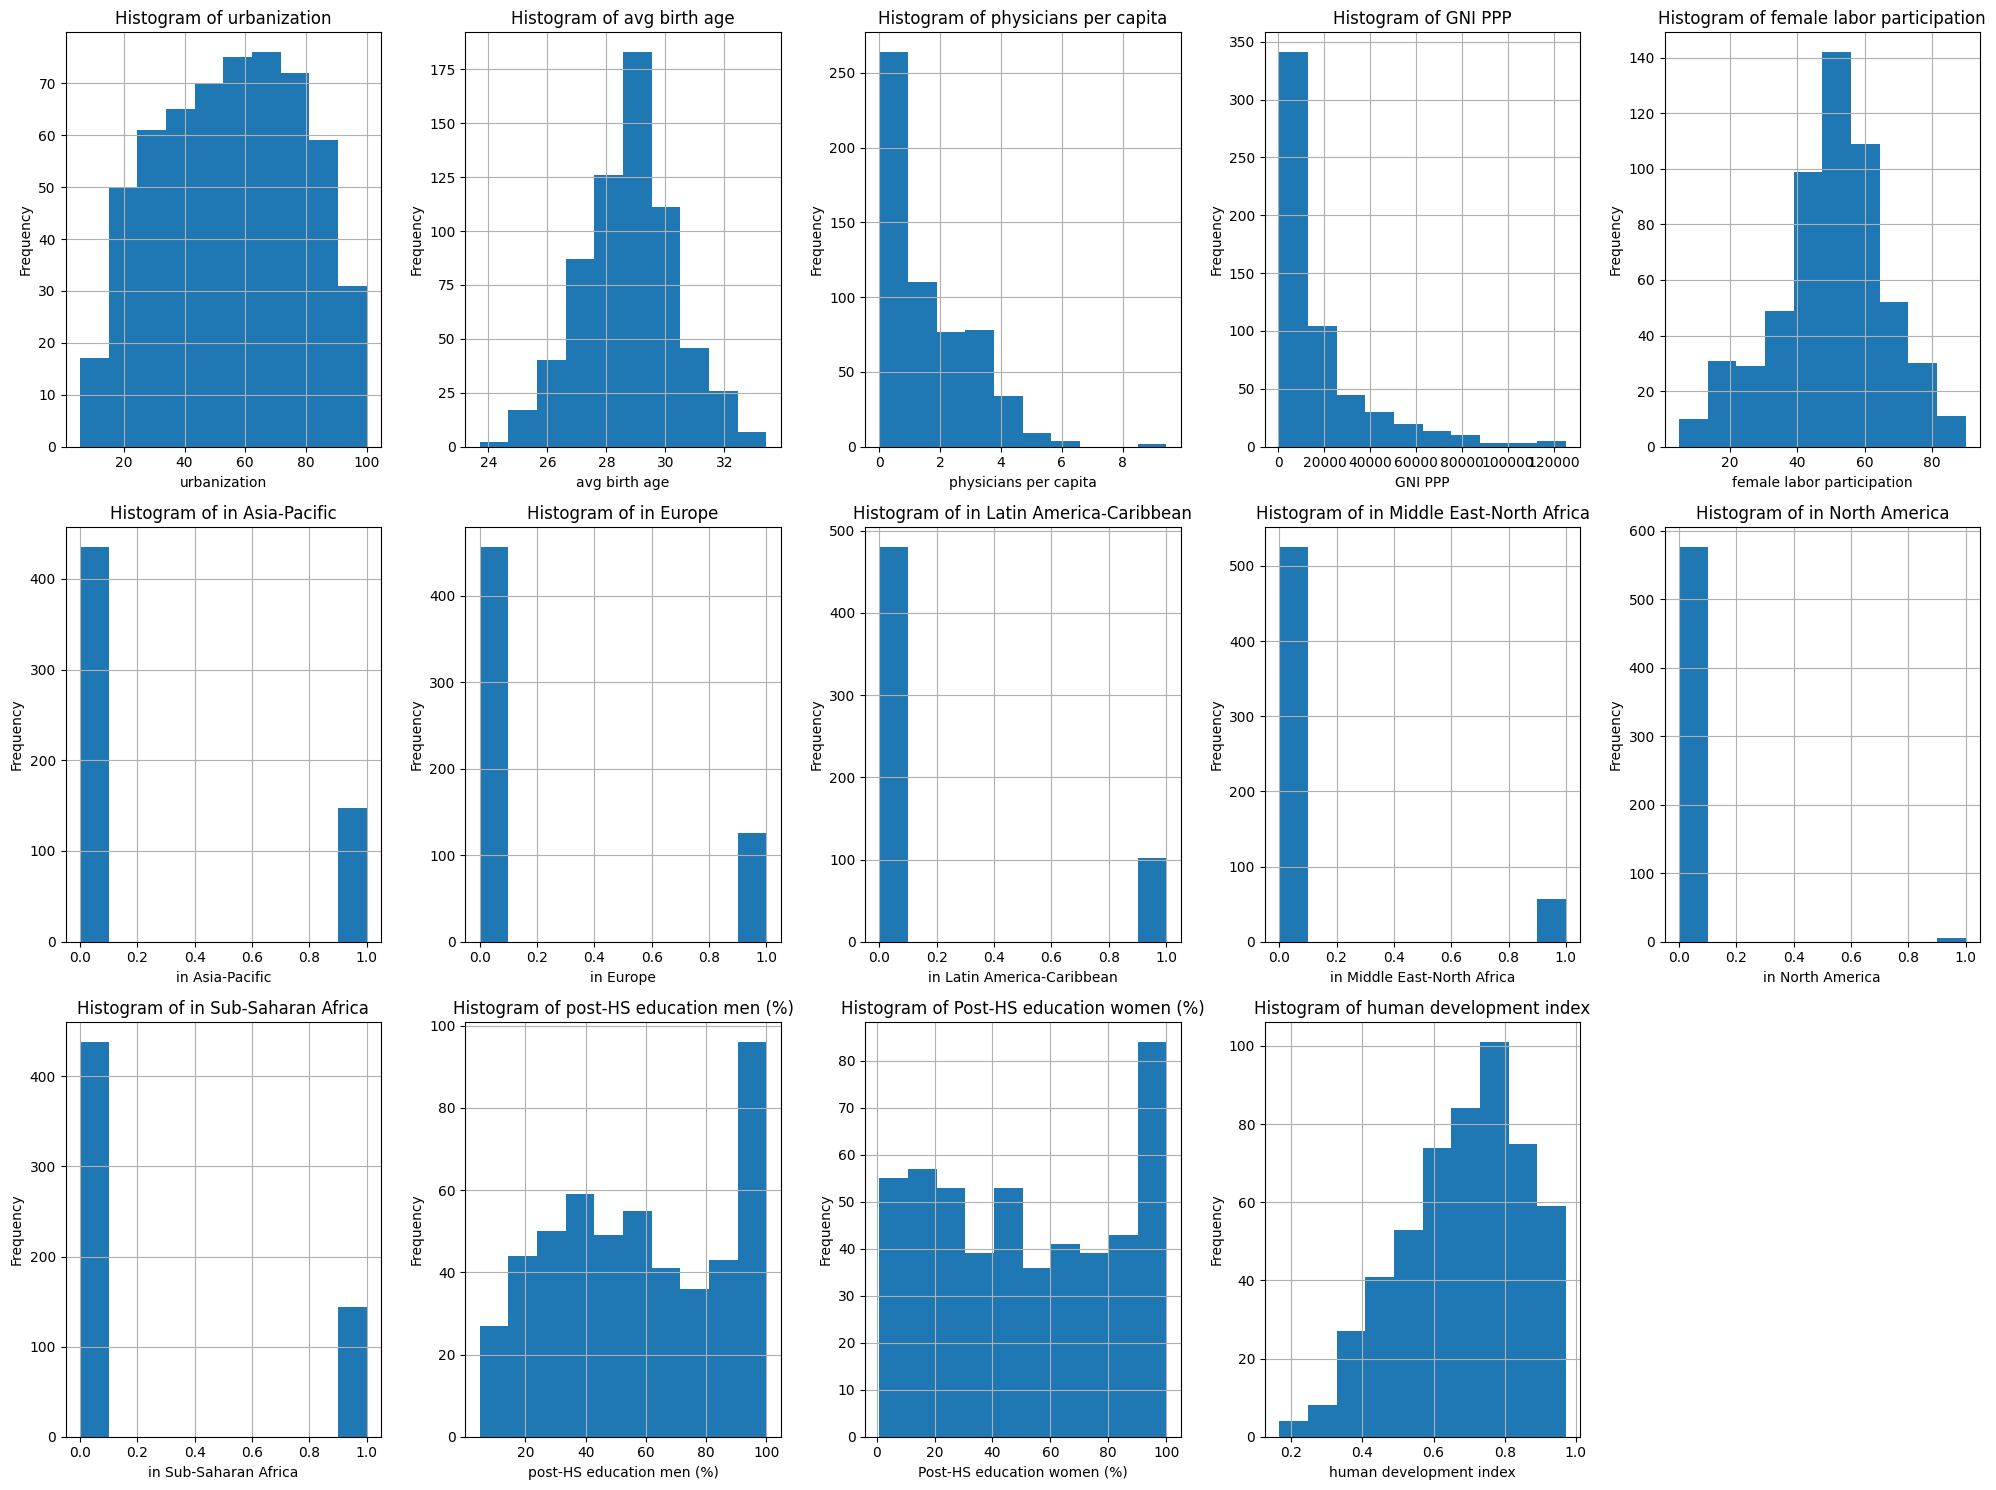

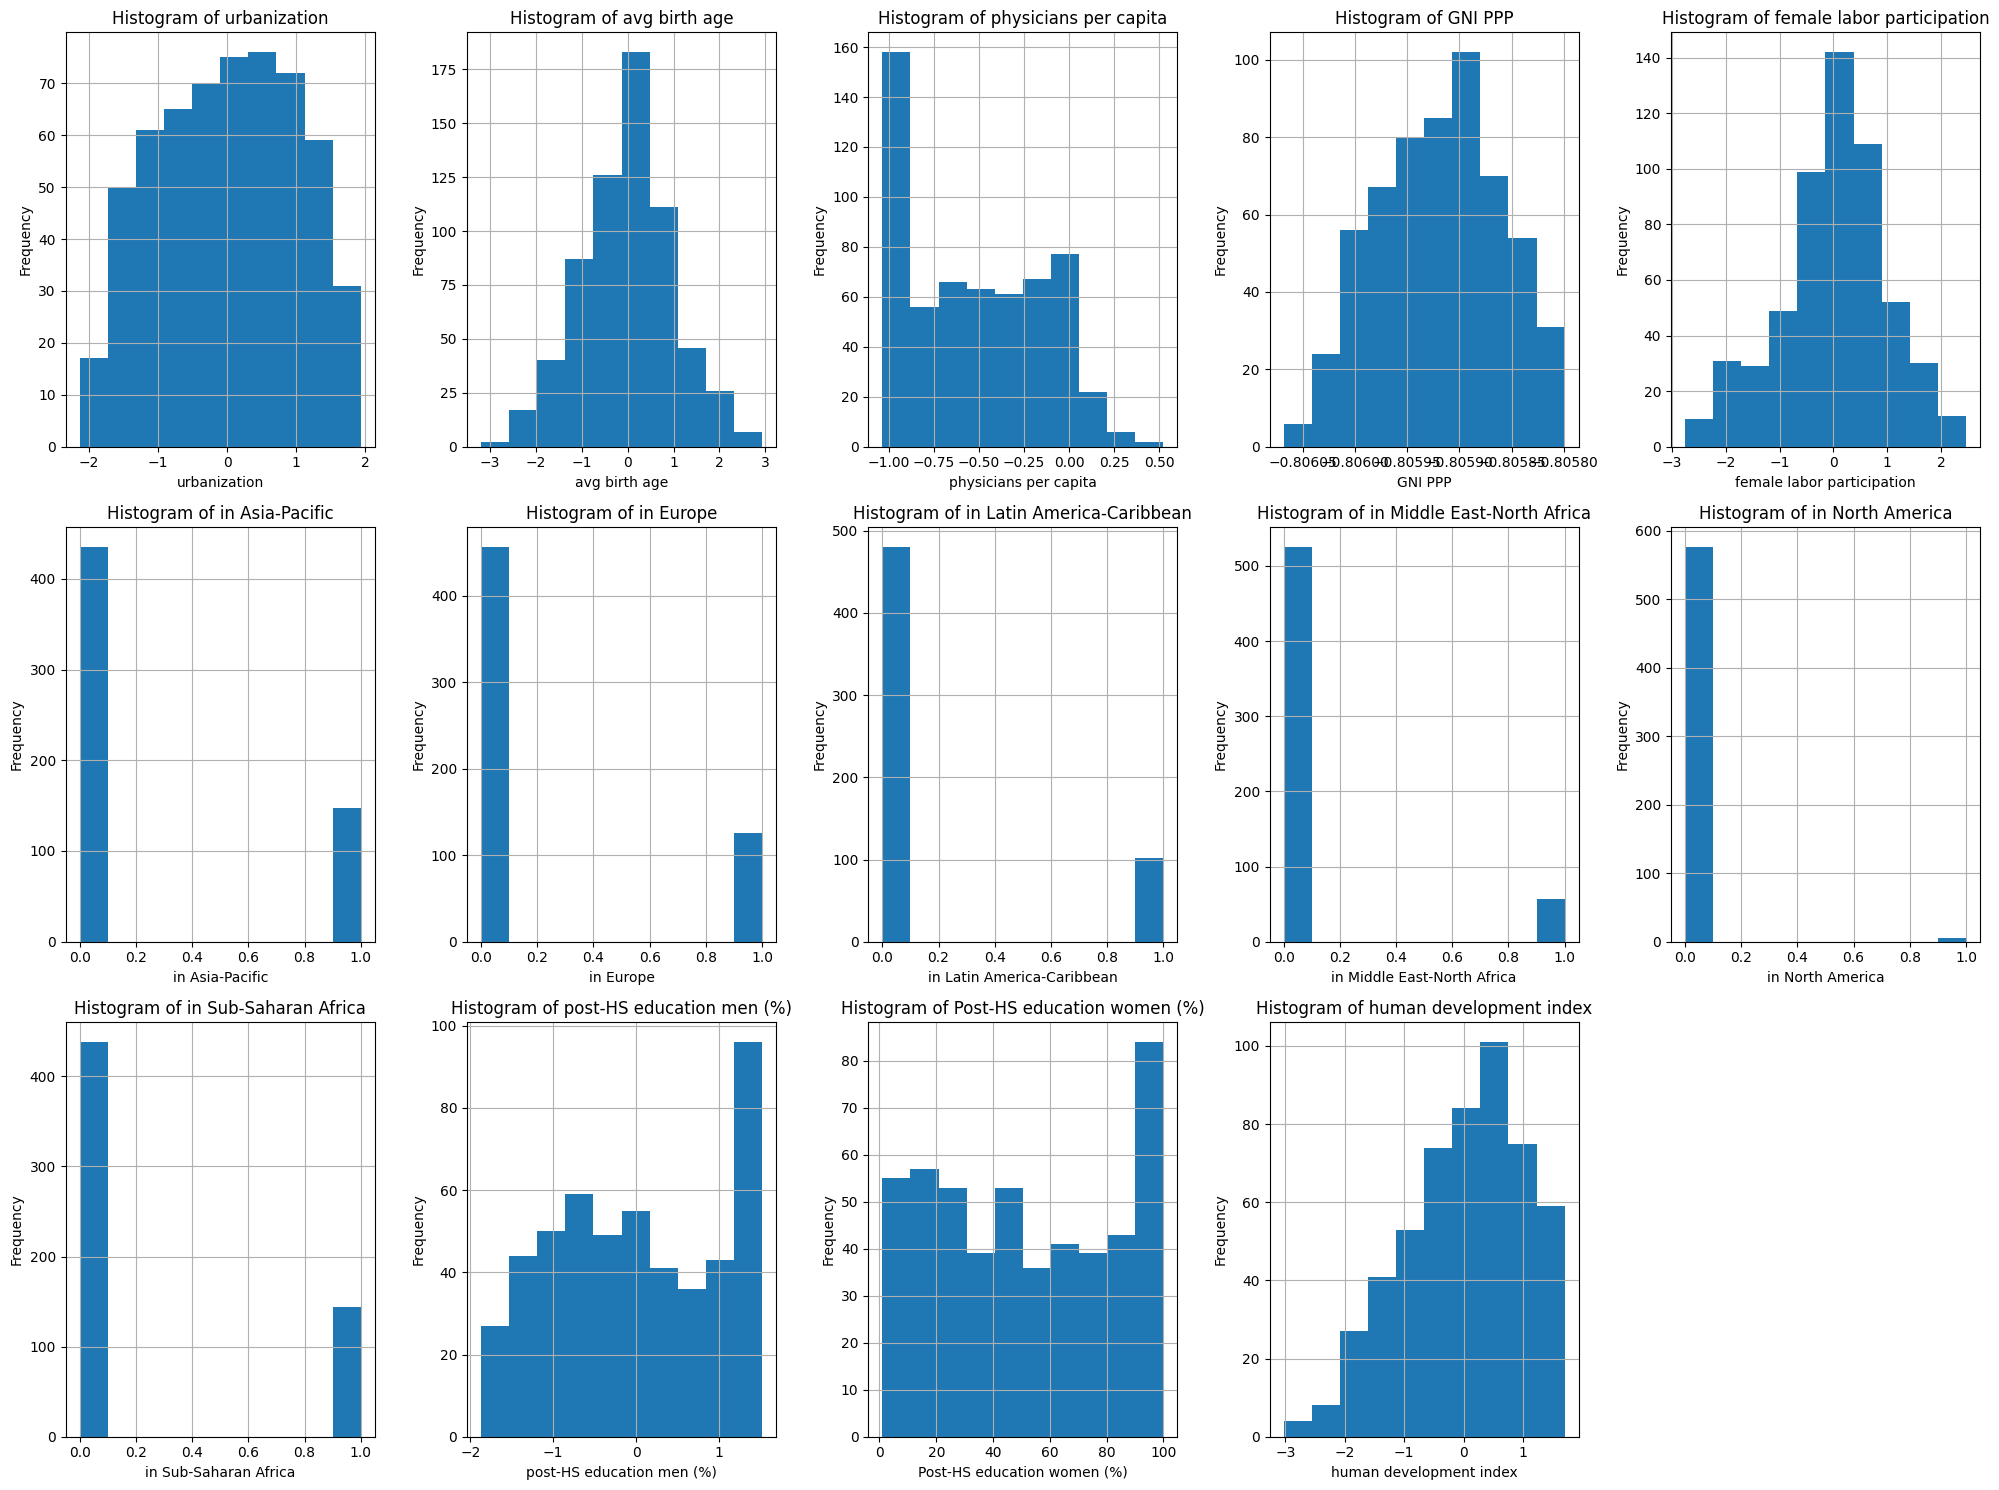

In [10]:
data = init_process()
def process_multi_year_data(data_output):
  years = [2023, 2007, 1991]
  all_features = []
  all_targets = []

  for year in years:
      df_features, target = calc_features_year(data, year)
      all_features.append(df_features)
      all_targets.extend(target)

  X = pd.concat(all_features)
  Y = pd.Series(all_targets, index=X.index, name='target')

  columns_to_drop = [
      'christians (%)', 'muslims (%)', 'no religion (%)', 'buddhists (%)',
      'hindus (%)', 'jews (%)', 'other religion (%)', 'gender inequality index',
      'happiness index', 'first marriage age women', 'first marriage age men',
      'work hours men', 'work hours women', 'social media users', 'abortion rate',
      'health expenditure' ,'maternity leave index'
  ]

  X = X.drop(columns=columns_to_drop)
  X = X.apply(pd.to_numeric, errors='coerce')

  # Add specific missing data points (structured by feature)
  missing_values_to_fill_manual = {
      'GNI PPP': {
          ('Venezuela, RB', 2023): 20017,
          ('Syrian Arab Republic', 2007): 3914.3,
          ('Nigeria', 2007): 3260.8,
          ('Afghanistan', 1991): 1070
      },
      'female labor participation': {
          ('Grenada', 2023): 51.42
      },
      'physicians per capita': {
          ('Hong Kong SAR, China', 2023): 2.1,
          ('Hong Kong SAR, China', 2007): 1.13,
          ('India', 2007): 0.61
      },
      'urbanization': {
          ('West Bank and Gaza', 2023): 77.58,
          ('West Bank and Gaza', 2007): 73.49,
          ('South Sudan', 2023): 21.56,
          ('Montenegro', 2023): 68.5,
          ('Montenegro', 2007): 63.14,
          ('Maldives', 2023): 42.41,
          ('Maldives', 2007): 35.2,
          ('Serbia', 2023): 57.11,
          ('Serbia', 2007): 54.33
      },
      'human development index': {
          ('Sudan', 2007): 0.526,
          ('Rwanda', 1991): 0.213,
          ('Sao Tome and Principe', 1991): 0.399,
          ('Liberia', 1991): 0.22,
          ('Ethiopia', 1991): 0.166
      }
  }

  for feature, country_year_values in missing_values_to_fill_manual.items():
      if feature in X.columns:
          for (country, year), value in country_year_values.items():
              if (country, year) in X.index:
                  X.loc[(country, year), feature] = value

  train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=42)
  return train_X, test_X, train_y, test_y
  # Use ScalingMultiYear for transformation and scaling
  scaler = ScalingMultiYear()
  scaler.fit(X)
  X_scaled = scaler.transform(X)


  # Plot histograms of the scaled features
  plot_features(X)
  plot_features(X_scaled)


In [7]:
class ScalingMultiYear(BaseEstimator, TransformerMixin):
    def __init__(self,log_features=None,features_to_scale=None,health_features=None):
        self.log_features=log_features or ['GNI PPP','physicians per capita']
        self.features_to_scale=features_to_scale or [
            'urbanization','avg birth age','GNI PPP',
            'female labor participation','post-HS education men (%)',
            'post-HS education men (%)','human development index',
            'physicians per capita'
        ]
        self.scaler=StandardScaler()

    def fit(self,X,y=None):
        X_copy=X.copy()
        self.scaler.fit(X_copy[self.features_to_scale])
        return self

    def transform(self,X):
        X_copy=X.copy()
        for f in self.log_features:
            X_copy[f]=pd.to_numeric(X_copy[f])
            X_copy[f]=np.log1p(X_copy[f])
        X_copy[self.features_to_scale]=self.scaler.transform(X_copy[self.features_to_scale])
        return X_copy

In [10]:
# Filter for countries with unscaled GNI PPP less than 0
countries_with_low_gni = combined_df_features[combined_df_features['GNI PPP'] < 0]

# Print the countries and their GNI PPP values
print("Countries with unscaled GNI PPP smaller than 0:")
display(countries_with_low_gni[['GNI PPP']])

Countries with unscaled GNI PPP smaller than 0:


,,GNI PPP
country,year,
South Sudan,2023,-2266.666667


In [9]:
find_missing_features(combined_df_features)

Countries with NaN values in their features:
[('American Samoa', 2023), ('Andorra', 2023), ('Antigua and Barbuda', 2023), ('Aruba', 2023), ('Bermuda', 2023), ('British Virgin Islands', 2023), ('Cayman Islands', 2023), ('Channel Islands', 2023), ('Cuba', 2023), ('Curacao', 2023), ('Dominica', 2023), ('Equatorial Guinea', 2023), ('Eritrea', 2023), ('Faroe Islands', 2023), ('French Polynesia', 2023), ('Gibraltar', 2023), ('Greenland', 2023), ('Grenada', 2023), ('Guam', 2023), ('Hong Kong SAR, China', 2023), ('Isle of Man', 2023), ('Kiribati', 2023), ("Korea, Dem. People's Rep.", 2023), ('Kosovo', 2023), ('Liechtenstein', 2023), ('Macao SAR, China', 2023), ('Maldives', 2023), ('Marshall Islands', 2023), ('Micronesia, Fed. Sts.', 2023), ('Monaco', 2023), ('Montenegro', 2023), ('Nauru', 2023), ('New Caledonia', 2023), ('Northern Mariana Islands', 2023), ('Palau', 2023), ('Puerto Rico (US)', 2023), ('San Marino', 2023), ('Serbia', 2023), ('Seychelles', 2023), ('Sint Maarten (Dutch part)', 202

In [52]:

print(process_2023_data(init_process()))
"""
countries = sorted(list(set([key[0] for key in data.keys()])))
index=[(country, 2023) for country in countries]
for key in index:
  print(key in data)
"""

Downloaded extract_data.py to data_extraction_code/extract_data.py
Downloaded GNI_PPP_const_2021_dollars.csv to data/GNI_PPP_const_2021_dollars.csv
Downloaded Religious-Composition-percentages.csv to data/Religious-Composition-percentages.csv
Downloaded abortion-rates-by-country-2025.csv to data/abortion-rates-by-country-2025.csv
Downloaded age-at-first-marriage-by-country-2025.csv to data/age-at-first-marriage-by-country-2025.csv
Downloaded average-workweek-by-country-2025.csv to data/average-workweek-by-country-2025.csv
Downloaded female-labor-force-participation-rates-slopes.csv to data/female-labor-force-participation-rates-slopes.csv
Downloaded female-labor-participation.csv to data/female-labor-participation.csv
Downloaded gender-inequality-index.xlsx to data/gender-inequality-index.xlsx
Downloaded happiness-cantril-ladder.csv to data/happiness-cantril-ladder.csv
Downloaded healthcare-expenditure-per-capita-ppp.csv to data/healthcare-expenditure-per-capita-ppp.csv
Downloaded high

'\ncountries = sorted(list(set([key[0] for key in data.keys()])))\nindex=[(country, 2023) for country in countries]\nfor key in index:\n  print(key in data)\n'